
# 🎬 MovieLens Database & EDA — **Solution Notebook**

This notebook implements the full workflow specified in the **Self‑Practice Exercise – MovieLens Database & EDA**: downloading the dataset, loading it into **MySQL** with **SQLAlchemy**, reading back with **Pandas**, and performing **manual** and **automatic** EDA. 

> Tools used: NumPy, Pandas, MySQL (via SQLAlchemy), Matplotlib (for plots), and automated EDA (ydata‑profiling / Sweetviz).



## 0) Environment
- Python ≥ 3.10
- MySQL server available locally or remote
- Recommended: `pip install pandas numpy sqlalchemy mysql-connector-python matplotlib ydata-profiling sweetviz`

> If you cannot use MySQL, see the **SQLite fallback** cell later.


In [1]:

# --- Imports ---
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile
from io import BytesIO
import requests

from sqlalchemy import create_engine, text

# Display settings
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)



## 1) Download & Extract MovieLens ZIP
We'll fetch **ml-latest-small.zip** directly from GroupLens and load `ratings.csv` and `movies.csv` into DataFrames.


In [2]:

url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
print("Downloading:", url)
r = requests.get(url, timeout=60)
r.raise_for_status()

z = ZipFile(BytesIO(r.content))
ratings = pd.read_csv(z.open("ml-latest-small/ratings.csv"))
movies  = pd.read_csv(z.open("ml-latest-small/movies.csv"))

print("ratings shape:", ratings.shape)
print("movies shape :", movies.shape)
display(ratings.head())
display(movies.head())


Downloading: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
ratings shape: (100836, 4)
movies shape : (9742, 3)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



## 2) Save to MySQL
Create a database **movielens** and write the tables using `to_sql`.  
**Fill your credentials** below. If you do not have MySQL available, skip to the **SQLite fallback** cell.


In [3]:

# ---- MySQL connection (edit me) ----
MYSQL_USER = os.getenv("MYSQL_USER", "root")
MYSQL_PASS = os.getenv("MYSQL_PASSWORD", "AIdev2025")
MYSQL_HOST = os.getenv("MYSQL_HOST", "127.0.0.1")
MYSQL_PORT = int(os.getenv("MYSQL_PORT", "3306"))
MYSQL_DB   = os.getenv("MYSQL_DB", "demo_llm")


mysql_url = f"mysql+mysqlconnector://{MYSQL_USER}:{MYSQL_PASS}@{MYSQL_HOST}:{MYSQL_PORT}/"

# Create database if not exists, then connect to it
try:
    engine_admin = create_engine(mysql_url, pool_pre_ping=True)
    with engine_admin.connect() as conn:
        conn.execute(text(f"CREATE DATABASE IF NOT EXISTS {MYSQL_DB}"))
        print(f"Database ensured: {MYSQL_DB}")
except Exception as e:
    print("MySQL admin connection failed:", repr(e))

# Connect to the movielens DB
engine = None
try:
    engine = create_engine(mysql_url + MYSQL_DB, pool_pre_ping=True)
    with engine.begin() as conn:
        conn.execute(text("SELECT 1"))
    print("Connected to MySQL movielens DB.")
except Exception as e:
    print("MySQL DB connection failed:", repr(e))

if engine is not None:
    # Write tables
    ratings.to_sql("ratings", engine, if_exists="replace", index=False)
    movies.to_sql("movies", engine, if_exists="replace", index=False)
    print("Tables written: ratings, movies")


Database ensured: demo_llm
Connected to MySQL movielens DB.
Tables written: ratings, movies



### (Optional) SQLite Fallback
If MySQL is not available, uncomment and run the cell below to persist to a local SQLite DB (`movielens.db`).  
> This deviates from the original MySQL requirement but allows you to complete all subsequent steps.


In [4]:

# # --- SQLite fallback ---
# import sqlite3
# sqlite_path = "movielens.db"
# sqlite_engine = create_engine(f"sqlite:///{sqlite_path}")
# ratings.to_sql("ratings", sqlite_engine, if_exists="replace", index=False)
# movies.to_sql("movies", sqlite_engine, if_exists="replace", index=False)
# engine = sqlite_engine  # <-- downstream cells will use `engine`
# print("SQLite DB created at:", sqlite_path)



## 3) Query Back into Pandas
Read the `ratings` and `movies` tables from the database and verify row counts.


In [5]:

assert engine is not None, "No database engine found. Ensure MySQL connection succeeded or use the SQLite fallback."
ratings_db = pd.read_sql("SELECT * FROM ratings", engine)
movies_db  = pd.read_sql("SELECT * FROM movies", engine)

print("ratings_db shape:", ratings_db.shape, " | movies_db shape:", movies_db.shape)
assert len(ratings_db) == len(ratings), "Row count mismatch for ratings."
assert len(movies_db)  == len(movies),  "Row count mismatch for movies."


ratings_db shape: (100836, 4)  | movies_db shape: (9742, 3)



## 4) Manual EDA

We will:
1. Inspect structure with `info()` and `describe()`  
2. Join ratings ⨝ movies  
3. **Top 10 movies by average rating** (min 20 ratings)  
4. **Histogram** of ratings  
5. **Average rating per genre** (explode genres)  
6. **Scatter** of rating count vs average rating

> Plots are done with **Matplotlib**.


In [6]:

# 4.1 Structure
display(ratings_db.info())
display(ratings_db.describe())
display(movies_db.info())
display(movies_db.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [7]:

# 4.2 Join ratings with movies
df = ratings_db.merge(movies_db, on="movieId", how="left")
df.head()


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [8]:

# 4.3 Top 10 movies by average rating (min_n ratings threshold)
min_n = 20
agg = (df.groupby(["movieId", "title"])["rating"]
         .agg(avg_rating="mean", n_ratings="count")
         .reset_index())
top10 = agg.loc[agg["n_ratings"] >= min_n].sort_values(["avg_rating","n_ratings"], ascending=[False, False]).head(10)
top10


,movieId,title,avg_rating,n_ratings
840,1104,"Streetcar Named Desire, A (1951)",4.475000,20
277,318,"Shawshank Redemption, The (1994)",4.429022,317
704,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.333333,27
680,898,"Philadelphia Story, The (1940)",4.310345,29
905,1204,Lawrence of Arabia (1962),4.300000,45
413,475,In the Name of the Father (1993),4.300000,25
210,246,Hoop Dreams (1994),4.293103,29
659,858,"Godfather, The (1972)",4.289062,192
934,1235,Harold and Maude (1971),4.288462,26
9445,168252,Logan (2017),4.280000,25


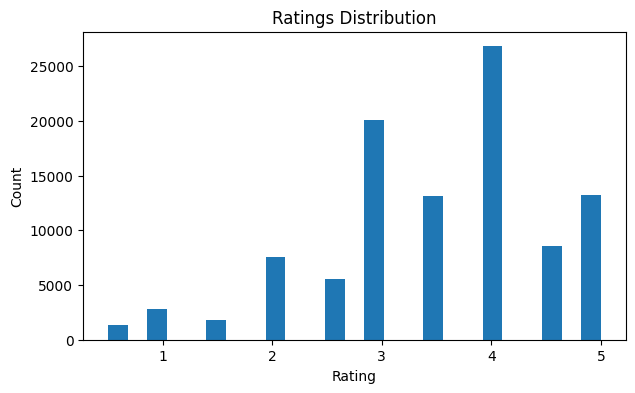

In [9]:

# 4.4 Histogram of ratings distribution
plt.figure(figsize=(7,4))
plt.hist(df["rating"].values, bins=25)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Ratings Distribution")
plt.show()


In [10]:

# 4.5 Average rating per genre
# Split pipe-delimited genres into rows
genres_exploded = (df.assign(genres=df["genres"].str.split("|"))
                     .explode("genres"))
genres_exploded = genres_exploded[genres_exploded["genres"].notna() & (genres_exploded["genres"] != "(no genres listed)")]

genre_stats = (genres_exploded.groupby("genres")["rating"]
               .agg(avg_rating="mean", n="count")
               .reset_index()
               .sort_values("avg_rating", ascending=False))
genre_stats.head(20)


,genres,avg_rating,n
9,Film-Noir,3.920115,870
17,War,3.808294,4859
6,Documentary,3.797785,1219
5,Crime,3.658294,16681
7,Drama,3.656184,41928
13,Mystery,3.632460,7674
2,Animation,3.629937,6988
11,IMAX,3.618335,4145
18,Western,3.583938,1930
12,Musical,3.563678,4138


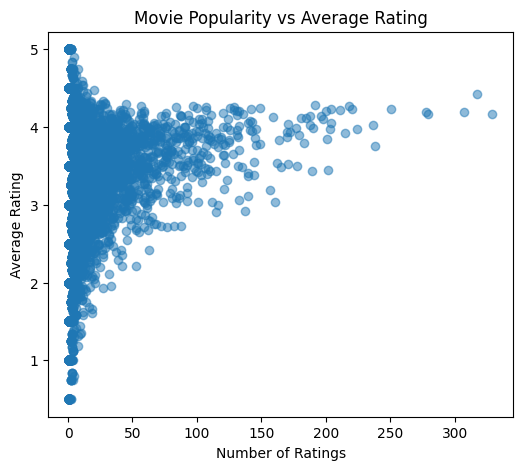

In [11]:

# 4.6 Scatter: rating count vs average rating (per movie)
plt.figure(figsize=(6,5))
plt.scatter(agg["n_ratings"], agg["avg_rating"], alpha=0.5)
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.title("Movie Popularity vs Average Rating")
plt.show()



## 5) Automatic EDA
We'll demonstrate two options. You can use either one.

### Option A: ydata‑profiling (formerly pandas‑profiling)
```bash
pip install ydata-profiling
```
### Option B: Sweetviz
```bash
pip install sweetviz
```


In [12]:
# %pip install ydata-profiling

In [13]:

# --- Option A: ydata-profiling (uncomment to run) ---
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="MovieLens Ratings ⨝ Movies - Profile", explorative=True)
profile_path = "profiling_movielens_report.html"
profile.to_file(profile_path)
print("Profile report saved to:", profile_path)


c:\Users\zvibe\anaconda3\envs\AI_dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 160.80it/s]

Profile report saved to: profiling_movielens_report.html


In [15]:

# --- Option B: Sweetviz (uncomment to run) ---
import sweetviz as sv
report = sv.analyze(df)
sweetviz_path = "sweetviz_movielens_report.html"
report.show_html(filepath=sweetviz_path, open_browser=False)
print("Sweetviz report saved to:", sweetviz_path)


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)

Report sweetviz_movielens_report.html was generated.
Sweetviz report saved to: sweetviz_movielens_report.html



## 6) Compare Automated vs Manual Findings
- Validate the **top movies** discovered manually.
- Check if **genre averages** align with automated EDA insights.
- Note any **data quality** warnings (e.g., skew, missingness) highlighted by the automated tool.



## (Optional) Performance Tips
- Add indices in SQL on `ratings(movieId)`, `ratings(userId)`, `movies(movieId)` for faster joins.
- Cache `df` to Parquet for rapid reloads during EDA.



---

### ✅ Checklist (from the exercise)
1. Download & extract ZIP; preview `ratings` and `movies`  
2. Create DB and load data to MySQL  
3. Query back into Pandas and confirm row counts  
4. Manual EDA: Top 10 (min 20), avg by genre, histogram, scatter  
5. Automatic EDA: Generate profile and compare insights  

> You’re done! 🎉
